In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
%matplotlib inline
import time, sys
from scipy.sparse import spdiags
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# load FOM solution
u=pickle.load(open("./data/FOM.p",'rb'))

In [3]:
# load weights and bias
file_name_POD="./model/POD_v2.p"

POD = pickle.load(open(file_name_POD,'rb'))

phi=np.copy(POD)

f=phi.shape[1]

In [4]:
def DEIM(phi_f, nfeval=None):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    if nfeval==None:
        nfeval=m
        
    if nfeval<m:
        print("ill-posed\n")
        print("set # sampling equal to # modes")
        nfeval=m
        
    div,mod=np.divmod(nfeval,m)
    
    I=np.eye(n)
    
    l=0
    ns=div+mod
    u=np.reshape(phi_f[:,l],(n,1))
    p=np.argsort(-np.abs(u),axis=0,kind='stable')[:ns]
#     p=np.argmax(np.abs(u)) # when ns=1
    ep=np.reshape(I[:,p],(n,ns))
    U=u
    P=ep

    ns=div
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        PT=np.transpose(P)
        c=np.linalg.lstsq(PT@U,PT@u,rcond=None)[0]
        r=np.abs(u-U@c)
        r[p]=ninf
        p=np.append(p,np.argsort(-r,axis=0,kind='stable')[:ns]) # ns!=1
        ep=np.reshape(I[:,p[-ns:]],(n,ns))
        U=np.concatenate((U,u),axis=1)
        P=np.concatenate((P,ep),axis=1)
        
    return p

In [5]:
def residual_lspg_hr(uwn_z,u_sb,z0_ind,z1_ind,c):
    
    # u_sb is subnet of u
    # z_union[z0_ind] gives z0, which is z
    # z_union[z1_ind] igves z1, which is z-1
    
    r = -uwn_z + u_sb[z0_ind] + c*(u_sb[z0_ind]**2 - u_sb[z0_ind]*u_sb[z1_ind])
    
    return r

def jacobian_lspg_hr(u_sb,phi_sbT,z0_ind,z1_ind,c):
    
    # phi_sb is subnet of phi
    
    J = ((1.0 + c*(2*u_sb[z0_ind] - u_sb[z1_ind]))*phi_sbT[:,z0_ind]).T + (-c*u_sb[z0_ind]*phi_sbT[:,z1_ind]).T
    
    return J

In [6]:
amp = 1.0
width = 1.0

convergence_threshold = 1.0e-6
maxk = 10

nx = 1001
dx = 2.0 / (nx - 1)
nt = 500
dt = 0.5 / nt  

c = dt/dx

x = np.linspace(0, 2, nx)

idxn1=np.zeros(nx-1,dtype='int')
idxn1[1:]=np.arange(nx-2)
idxn1[0]=nx-2

u0 = np.copy(u[0])
u_hat0=np.zeros(f)

In [7]:
# load snapshot
snapshot_full=pickle.load(open('./data/snapshot_full.p','rb'))
DEIM_snapshot=snapshot_full[:,:-1]

# Do SVD
Ur,Sr,VrT=np.linalg.svd(DEIM_snapshot.T,full_matrices=False)
# plt.figure()
# plt.semilogy(Sr)
# plt.show()

In [8]:
DEIM_test_tstart=time.time()

# choose # of DEIM basis and DEIM samples
DEIM_min=30
DEIM_max=50

n_test=int((DEIM_max-DEIM_min)*(DEIM_max-DEIM_min+1)/2)
print('Total # of test: {}'.format(n_test))

# save test results: [DEIM_basis, DEIM_samples, Time_elapsed, Max_rel_err]
test_results=np.zeros((n_test,4))

test_count=0
for DEIM_basis in np.arange(DEIM_min,DEIM_max):
    for DEIM_samples in np.arange(DEIM_basis,DEIM_max):
        test_count+=1
        print()
        print('Test #{}'.format(test_count))
        print('-'*72)
        print('DEIM_basis: {}, DEIM_samples: {}'.format(DEIM_basis,DEIM_samples))
        
        try:
            # precompute
            phi_r=Ur[:,:DEIM_basis]
            z=DEIM(phi_r,DEIM_samples)
            ZT=np.eye(nx-1)[z]
            Z=ZT.T
            precomp1=phi_r@np.linalg.pinv(ZT@phi_r)
            precomp=precomp1.T@precomp1

            # influential indices
            z_union=np.zeros((z.size,2),dtype='int')
            for i in range(z.size):
                if z[i]==0:
                    z_union[i,0]=0
                    z_union[i,1]=nx-2
                else:
                    z_union[i,0]=z[i]
                    z_union[i,1]=z[i]-1        
            z0=z_union[:,0]
            z1=z_union[:,1]

            z_union=np.unique(z_union.flatten())

            z_union0_ind=np.zeros(z0.size,dtype='int')
            z_union1_ind=np.zeros(z1.size,dtype='int')
            for i in range(z0.size):
                z_union0_ind[i]=np.nonzero(np.isin(z_union,z0[i]))[0]
                z_union1_ind[i]=np.nonzero(np.isin(z_union,z1[i]))[0]

            # Construct subnet
            phi_sb=phi[z_union]
            phi_sbT=phi_sb.T

            # Run NM-ROM-DEIM
            t_total_rom_hr_start=time.time()

            u_rom_lspg_hr = np.zeros((nt+1,nx))
            u_rom_lspg_hr[0] = u0
            u_hat = np.zeros((nt+1,f))
            u_hat[0] = u_hat0
            I_hat = np.eye(f)
            for n in range(nt): 
            #     print("")
            #     print(n,"th time step:")
                u_hatw = u_hat[n].copy()

                uw_sb = u0[z_union] + phi_sb.dot(u_hatw)

                J_lspg = jacobian_lspg_hr(uw_sb,phi_sbT,z_union0_ind,z_union1_ind,c)
                J_lspgT = J_lspg.T

                r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw_sb,z_union0_ind,z_union1_ind,c)
                r = J_lspgT.dot(precomp.dot(r_lspg))

                for k in range(maxk):   
                    J = J_lspgT@precomp@J_lspg

                    du_hatw = np.linalg.solve(J,-r)

                    u_hatw = u_hatw + du_hatw

                    uw_sb = u0[z_union] + phi_sb.dot(u_hatw)

                    J_lspg = jacobian_lspg_hr(uw_sb,phi_sbT,z_union0_ind,z_union1_ind,c)
                    J_lspgT = J_lspg.T

                    r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw_sb,z_union0_ind,z_union1_ind,c)
                    r = J_lspgT.dot(precomp.dot(r_lspg))

                    res = np.linalg.norm(r)
            #         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))

                    if res < convergence_threshold:
                        u_hat[n+1] = u_hatw.copy()
                        u_rom_lspg_hr[n+1,:-1] = u0[:-1] + phi.dot(u_hat[n+1])
                        u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]
                        break

                if res >= convergence_threshold:
            #         print("\n non converged after {}th iteration".format(maxk))
                    break

            #     u_hat[n+1] = u_hatw.copy()
            #     u_rom_lspg_hr[n+1,:-1] = u0[:-1] + phi.dot(u_hat[n+1])
            #     u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]

            t_total_rom_hr=time.time()-t_total_rom_hr_start
            print()
            print("Time elapsed: {} sec".format(t_total_rom_hr))

            # Compute errors
            rel_err=np.linalg.norm(u-u_rom_lspg_hr,axis=1)/np.linalg.norm(u,axis=1)*100
            avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg_hr,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
            max_rel_err = np.max(rel_err)         
            print()
            print("maximum relative error: {}%".format(max_rel_err))
            print('-'*72)      

            test_results[test_count-1]=[DEIM_basis,DEIM_samples,t_total_rom_hr,max_rel_err]              
        except np.linalg.LinAlgError as err:
            if 'Singular matrix' in str(err):
                print()
                print('Error due to singular matrix')
                print('-'*72)
                
                test_results[test_count-1]=[DEIM_basis,DEIM_samples,0.0,np.inf]
            else:
                print("Unexpected error:", sys.exc_info()[0])
                raise
        except:
            print("Unexpected error:", sys.exc_info()[0])
            raise

DEIM_test_telapsed=time.time()-DEIM_test_tstart
print()
print('DEIM test time elapsed: {} sec'.format(DEIM_test_telapsed))

Total # of test: 210

Test #1
------------------------------------------------------------------------
DEIM_basis: 30, DEIM_samples: 30

Time elapsed: 0.12703895568847656 sec

maximum relative error: 6.361437547734004%
------------------------------------------------------------------------

Test #2
------------------------------------------------------------------------
DEIM_basis: 30, DEIM_samples: 31

Time elapsed: 0.1295914649963379 sec

maximum relative error: 6.355390696514457%
------------------------------------------------------------------------

Test #3
------------------------------------------------------------------------
DEIM_basis: 30, DEIM_samples: 32

Time elapsed: 0.1341702938079834 sec

maximum relative error: 6.360792381285848%
------------------------------------------------------------------------

Test #4
------------------------------------------------------------------------
DEIM_basis: 30, DEIM_samples: 33

Time elapsed: 0.15992045402526855 sec

maximum relat


Time elapsed: 0.13183140754699707 sec

maximum relative error: 6.129545970438182%
------------------------------------------------------------------------

Test #33
------------------------------------------------------------------------
DEIM_basis: 31, DEIM_samples: 43

Time elapsed: 0.1360933780670166 sec

maximum relative error: 6.130962035343025%
------------------------------------------------------------------------

Test #34
------------------------------------------------------------------------
DEIM_basis: 31, DEIM_samples: 44

Time elapsed: 0.15337347984313965 sec

maximum relative error: 6.13110822071702%
------------------------------------------------------------------------

Test #35
------------------------------------------------------------------------
DEIM_basis: 31, DEIM_samples: 45

Time elapsed: 0.13275742530822754 sec

maximum relative error: 6.1323447818833445%
------------------------------------------------------------------------

Test #36
-------------------


Time elapsed: 0.13480305671691895 sec

maximum relative error: 6.188021144047448%
------------------------------------------------------------------------

Test #65
------------------------------------------------------------------------
DEIM_basis: 33, DEIM_samples: 40

Time elapsed: 0.1299457550048828 sec

maximum relative error: 6.18774147622461%
------------------------------------------------------------------------

Test #66
------------------------------------------------------------------------
DEIM_basis: 33, DEIM_samples: 41

Time elapsed: 0.13276171684265137 sec

maximum relative error: 6.186129516258769%
------------------------------------------------------------------------

Test #67
------------------------------------------------------------------------
DEIM_basis: 33, DEIM_samples: 42

Time elapsed: 0.13085699081420898 sec

maximum relative error: 6.1865915247912024%
------------------------------------------------------------------------

Test #68
-------------------


Time elapsed: 0.12960505485534668 sec

maximum relative error: 6.1278793881567655%
------------------------------------------------------------------------

Test #97
------------------------------------------------------------------------
DEIM_basis: 35, DEIM_samples: 41

Time elapsed: 0.13022994995117188 sec

maximum relative error: 6.12136926179376%
------------------------------------------------------------------------

Test #98
------------------------------------------------------------------------
DEIM_basis: 35, DEIM_samples: 42

Time elapsed: 0.13239288330078125 sec

maximum relative error: 6.120542734075872%
------------------------------------------------------------------------

Test #99
------------------------------------------------------------------------
DEIM_basis: 35, DEIM_samples: 43

Time elapsed: 0.1319599151611328 sec

maximum relative error: 6.120017850611387%
------------------------------------------------------------------------

Test #100
------------------


Time elapsed: 0.13245749473571777 sec

maximum relative error: 6.116972032561969%
------------------------------------------------------------------------

Test #129
------------------------------------------------------------------------
DEIM_basis: 37, DEIM_samples: 46

Time elapsed: 0.13222718238830566 sec

maximum relative error: 6.116457022155442%
------------------------------------------------------------------------

Test #130
------------------------------------------------------------------------
DEIM_basis: 37, DEIM_samples: 47

Time elapsed: 0.1328892707824707 sec

maximum relative error: 6.11712374853216%
------------------------------------------------------------------------

Test #131
------------------------------------------------------------------------
DEIM_basis: 37, DEIM_samples: 48

Time elapsed: 0.1315915584564209 sec

maximum relative error: 6.118429312638792%
------------------------------------------------------------------------

Test #132
-----------------


Time elapsed: 0.1316051483154297 sec

maximum relative error: 6.114330466662833%
------------------------------------------------------------------------

Test #161
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 45

Time elapsed: 0.13166022300720215 sec

maximum relative error: 6.11409005961466%
------------------------------------------------------------------------

Test #162
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 46

Time elapsed: 0.13411545753479004 sec

maximum relative error: 6.114165754664421%
------------------------------------------------------------------------

Test #163
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 47

Time elapsed: 0.13405323028564453 sec

maximum relative error: 6.113783141875483%
------------------------------------------------------------------------

Test #164
----------------


Time elapsed: 0.13436055183410645 sec

maximum relative error: 6.1240168246862705%
------------------------------------------------------------------------

Test #193
------------------------------------------------------------------------
DEIM_basis: 44, DEIM_samples: 47

Time elapsed: 0.13474774360656738 sec

maximum relative error: 6.122734404298804%
------------------------------------------------------------------------

Test #194
------------------------------------------------------------------------
DEIM_basis: 44, DEIM_samples: 48

Time elapsed: 0.1327512264251709 sec

maximum relative error: 6.123137015207763%
------------------------------------------------------------------------

Test #195
------------------------------------------------------------------------
DEIM_basis: 44, DEIM_samples: 49

Time elapsed: 0.13418030738830566 sec

maximum relative error: 6.1233739120459285%
------------------------------------------------------------------------

Test #196
-------------

In [9]:
print(test_results[np.argsort(test_results[:,-1])])

[[30.         47.          0.13996077  6.07469872]
 [30.         48.          0.13260341  6.07788251]
 [30.         49.          0.13385129  6.07792334]
 [31.         49.          0.23019385  6.09029658]
 [41.         49.          0.13502502  6.10901944]
 [41.         48.          0.13235497  6.10906791]
 [41.         46.          0.13240767  6.10910472]
 [41.         44.          0.13171744  6.10911881]
 [41.         42.          0.13217998  6.10915827]
 [41.         45.          0.13341045  6.1092425 ]
 [41.         47.          0.13523722  6.10930651]
 [41.         43.          0.1335969   6.10938664]
 [41.         41.          0.13292956  6.10943811]
 [40.         49.          0.13415241  6.11319195]
 [40.         48.          0.13455057  6.1136344 ]
 [40.         47.          0.13405323  6.11378314]
 [40.         45.          0.13166022  6.11409006]
 [40.         46.          0.13411546  6.11416575]
 [40.         43.          0.13229465  6.11422359]
 [40.         41.          0.13

# of residual basis: 30
# of residual sampes: 47

Time elapsed: 0.134232759475708 sec


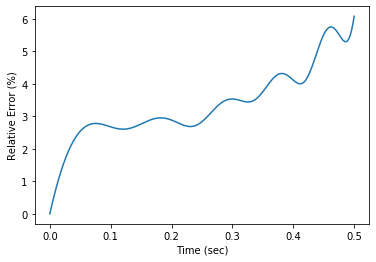

average relative error: 3.532369990874669%

maximum relative error: 6.074698721590355%
------------------------------------------------------------------------


In [10]:
# choose # of DEIM basis and DEIM samples
DEIM_basis=int(test_results[np.argsort(test_results[:,-1])[0]][0])
DEIM_samples=int(test_results[np.argsort(test_results[:,-1])[0]][1])
print('# of residual basis: {}'.format(DEIM_basis))
print('# of residual sampes: {}'.format(DEIM_samples))

# precompute
phi_r=Ur[:,:DEIM_basis]
z=DEIM(phi_r,DEIM_samples)
ZT=np.eye(nx-1)[z]
Z=ZT.T
precomp1=phi_r@np.linalg.pinv(ZT@phi_r)
precomp=precomp1.T@precomp1

# influential indices
z_union=np.zeros((z.size,2),dtype='int')
for i in range(z.size):
    if z[i]==0:
        z_union[i,0]=0
        z_union[i,1]=nx-2
    else:
        z_union[i,0]=z[i]
        z_union[i,1]=z[i]-1        
z0=z_union[:,0]
z1=z_union[:,1]

z_union=np.unique(z_union.flatten())

z_union0_ind=np.zeros(z0.size,dtype='int')
z_union1_ind=np.zeros(z1.size,dtype='int')
for i in range(z0.size):
    z_union0_ind[i]=np.nonzero(np.isin(z_union,z0[i]))[0]
    z_union1_ind[i]=np.nonzero(np.isin(z_union,z1[i]))[0]

# Construct subbasis
phi_sb=phi[z_union]
phi_sbT=phi_sb.T

# Run NM-ROM-DEIM
t_total_rom_hr_start=time.time()

u_rom_lspg_hr = np.zeros((nt+1,nx))
u_rom_lspg_hr[0] = u0
u_hat = np.zeros((nt+1,f))
u_hat[0] = u_hat0
I_hat = np.eye(f)
for n in range(nt): 
#     print("")
#     print(n,"th time step:")
    u_hatw = u_hat[n].copy()

    uw_sb = u0[z_union] + phi_sb.dot(u_hatw)

    J_lspg = jacobian_lspg_hr(uw_sb,phi_sbT,z_union0_ind,z_union1_ind,c)
    J_lspgT = J_lspg.T

    r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw_sb,z_union0_ind,z_union1_ind,c)
    r = J_lspgT.dot(precomp.dot(r_lspg))

    for k in range(maxk):   
        J = J_lspgT@precomp@J_lspg

        du_hatw = np.linalg.solve(J,-r)

        u_hatw = u_hatw + du_hatw

        uw_sb = u0[z_union] + phi_sb.dot(u_hatw)

        J_lspg = jacobian_lspg_hr(uw_sb,phi_sbT,z_union0_ind,z_union1_ind,c)
        J_lspgT = J_lspg.T

        r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw_sb,z_union0_ind,z_union1_ind,c)
        r = J_lspgT.dot(precomp.dot(r_lspg))

        res = np.linalg.norm(r)
#         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))

        if res < convergence_threshold:
            u_hat[n+1] = u_hatw.copy()
            u_rom_lspg_hr[n+1,:-1] = u0[:-1] + phi.dot(u_hat[n+1])
            u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]
            break

    if res >= convergence_threshold:
#         print("\n non converged after {}th iteration".format(maxk))
        break

#     u_hat[n+1] = u_hatw.copy()
#     u_rom_lspg_hr[n+1,:-1] = u0[:-1] + phi.dot(u_hat[n+1])
#     u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]

t_total_rom_hr=time.time()-t_total_rom_hr_start
print()
print("Time elapsed: {} sec".format(t_total_rom_hr))

# Compute errors
rel_err=np.linalg.norm(u-u_rom_lspg_hr,axis=1)/np.linalg.norm(u,axis=1)*100
avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg_hr,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
max_rel_err = np.max(rel_err)     

plt.plot(dt*np.arange(nt+1),rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.show()

print("average relative error: {}%".format(avg_rel_err))
print()
print("maximum relative error: {}%".format(max_rel_err))
print('-'*72)         